In [1]:
import os
import sys
sys.path.append('..')

import torch
import numpy as np
import pandas as pd
import selfies as sf
import matplotlib.pyplot as plt
from IPython.display import SVG, display

from rdkit import Chem
from rdkit.Chem import PandasTools

import moses
from moses.dataset import get_dataset
from moses.metrics.metrics import novelty
from moses.metrics.utils import canonic_smiles
from moses.vae.utils import VAEUtils
from moses.vae_property.utils import VAEPROPERTYUtils

# VAE model

In [2]:
# load the data
path = '../checkpoints/results_old/ZINC250K_vae_20240606_123048'
config = torch.load(os.path.join(path, 'vae_config.pt'))
vocab = torch.load(os.path.join(path, 'vae_vocab.pt'))
train = moses.get_dataset('train', config)

# Load a model

- Load a model and calculate sample mu and std

In [3]:
vae = VAEUtils(vocab, config, model_path=os.path.join(path, 'vae_model_080.pt'))

Model loaded from ../checkpoints/results_old/ZINC250K_vae_20240606_123048\vae_model_080.pt
Using standarized functions? True
Standarization: estimating mu and std values ...

0it [00:00, ?it/s]d:\Develop\7.UofT\ProjectCourse\NewMoses\notebooks\..\moses\vae_property\trainer.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  y_tensors = torch.tensor(y_sorted, dtype=torch.float32, device=device)
20it [00:14,  1.36it/s]

done!


In [4]:
config.use_selfies

False

# Using the VAE

## Encoder / Decoder


In [5]:
smiles_1 = canonic_smiles('CSCC(=O)NNC(=O)c1c(C)oc(C)c1C')

X_1 = [vae.model.string2tensor(smiles_1, device=vae.model.device)]
z_1 = vae.encode(X_1)
X_r= vae.decode(z_1)

print('{:20s} : {}'.format('Input',smiles_1))
print('{:20s} : {}'.format('Reconstruction',X_r[0]))

print('{:20s} : {} with norm {:.3f}'.format('Z representation',z_1.shape, np.linalg.norm(z_1)))

Input                : CSCC(=O)NNC(=O)c1c(C)oc(C)c1C
Reconstruction       : CC(C)C(=O)NCCNC(=O)Nc1ccc(F)cc1Cl
Z representation     : (1, 128) with norm 5.735


## Decode several attempts

In [6]:
vae.decode(z_1)

['CC(C)C(=O)NCCNC(=O)Nc1ccc(F)cc1Cl']

Searching molecules randomly sampled from 5.00 std (z-distance) from the point
Found 22 unique mols, out of 100
SMILES
 0               CC(C)C(=O)NCCNC(=O)Nc1ccc(Cl)cc1
1             CC(C)CC(C)NC(=O)CNC(=O)c1ccc(F)cc1
2                   CC(C)CC(=O)Nc1ccc(C(N)=O)cc1
3             CC(C)C(=O)N1CCC(C(=O)Nc2ccccc2)CC1
4            CC(C)CC(C)NC(=O)CNC(=O)c1ccc(Cl)cc1
5            CC(C)CC(=O)N1CCC(C(=O)Nc2ccccc2)CC1
6          CC(C)CC(C)N(C)C(=O)CNC(=O)c1ccc(F)cc1
7          CC(C)C(=O)N1CCC(C(=O)Nc2ccccc2C#N)CC1
8         CC(C)C(=O)N1CCC(C(=O)Nc2cccc(Cl)c2)CC1
9         CC(C)CC(C)N(C)C(=O)CNC(=O)c1ccc(Cl)cc1
10           CC(C)CC(=O)Nc1ccc(C(=O)N2CCCCC2)cc1
11          CC(C)CC(=O)Nc1ccc(C(=O)N2CCCCCC2)cc1
12          CC(C)CC(=O)Nc1ccc(NC(=O)c2ccccc2)cc1
13         CC(C)CC(=O)Nc1ccc(C(=O)NCc2ccccc2)cc1
14        CC(C)CC(=O)Nc1ccc(C(=O)NCCc2ccccc2)cc1
15      CC(C)(C)OC(=O)N1CCC(C(=O)NCCc2ccccc2)CC1
16      CC(C)C(=O)N1CCC(C(=O)Nc2ccc(Cl)cc2Cl)CC1
17        CC(C)(C)OC(=O)N1CCC(C(=O)NCC2CCCO2)CC

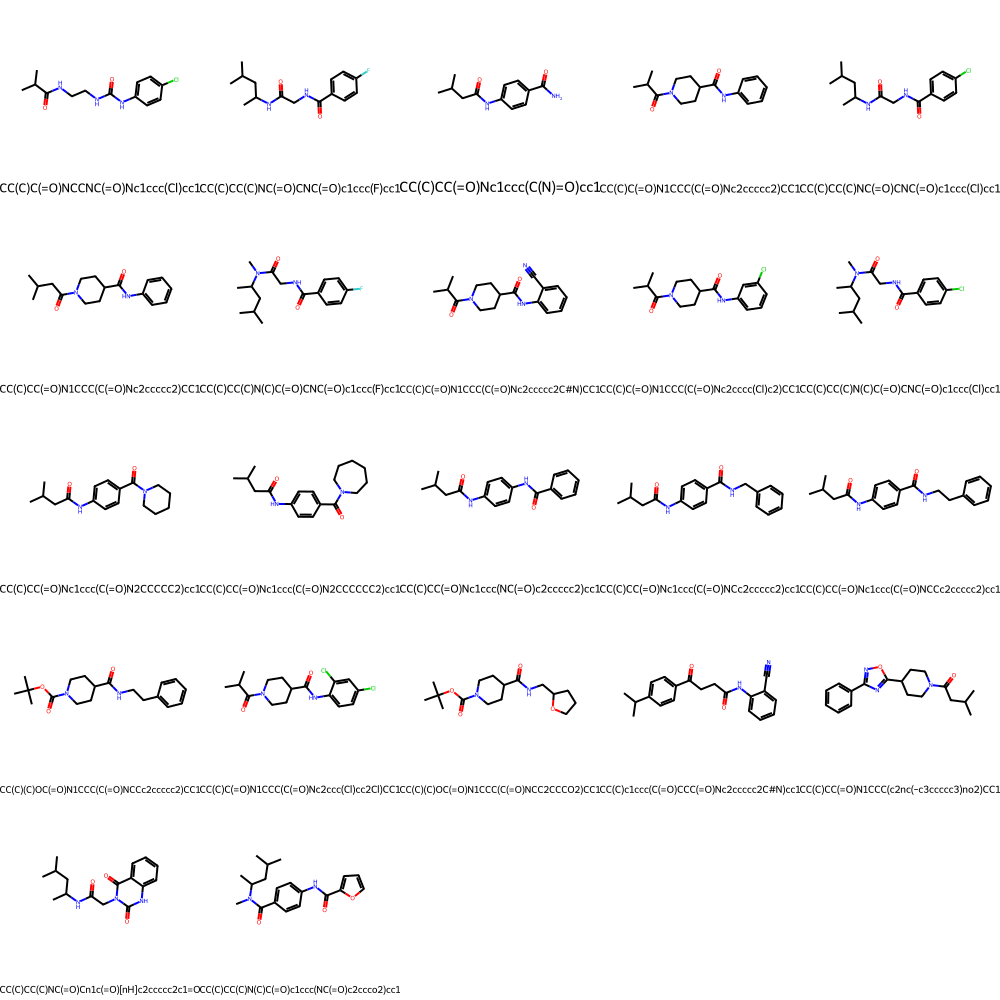

,smiles,distance,count,frequency,mol
0,CC(C)C(=O)NCCNC(=O)Nc1ccc(Cl)cc1,3.523651,3,0.03,<rdkit.Chem.rdchem.Mol object at 0x0000026B477...
1,CC(C)CC(C)NC(=O)CNC(=O)c1ccc(F)cc1,3.702037,3,0.03,<rdkit.Chem.rdchem.Mol object at 0x0000026B477...
2,CC(C)CC(=O)Nc1ccc(C(N)=O)cc1,3.844815,1,0.01,<rdkit.Chem.rdchem.Mol object at 0x0000026B477...
3,CC(C)C(=O)N1CCC(C(=O)Nc2ccccc2)CC1,3.965037,15,0.15,<rdkit.Chem.rdchem.Mol object at 0x0000026B477...
4,CC(C)CC(C)NC(=O)CNC(=O)c1ccc(Cl)cc1,4.111768,2,0.02,<rdkit.Chem.rdchem.Mol object at 0x0000026B477...


In [7]:
noise=5.0
print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point'.format(noise))
df = vae.z_to_smiles(z_1, decode_attempts=100, noise_norm=noise)
print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])),sum(df['count'])))
print('SMILES\n', df.smiles)
display(PandasTools.FrameToGridImage(df, column='mol', legendsCol='smiles', molsPerRow=5))
df.head()


## PCA of latent space

In [8]:
Z, data, smiles = vae.ls_sampler_w_prop(size=50000, return_smiles=True)
prop_opt = 'qed'
prop_df = pd.DataFrame(data, columns=vae.config.reg_prop_tasks)
prop_df['smiles'] = smiles
prop_df.head()

0it [00:00, ?it/s]

20it [00:15,  1.30it/s]


,logP,qed,SAS,obj,smiles
0,-0.755521,-1.404691,0.692896,-7.716353,Cc1nc(C)c(CC(=O)NCc2nc3ccc(C)c(C)c3[nH]2)c(=O)...
1,-0.812562,-0.558053,0.982514,-3.772778,O=S(=O)(c1c[nH]cn1)N1CCc2[nH]nc(-c3ccc(F)cc3)c2C1
2,0.414057,-1.487017,1.149614,-8.584701,COC(=O)c1[nH]c(C)c(C(=O)C(C)N(C)C(=O)c2cccs2)c1C
3,-3.431941,-1.511562,2.700821,-10.258630,O=C(NC1CC2C(=O)NCC(=O)N2C1)c1cc(C(F)(F)F)n[nH]1
4,-0.032002,-0.936884,-0.772466,-3.911956,CCn1c(=O)c(=O)[nH]c2cc(C(=O)Nc3ccc(F)cc3C)ccc21


Explained variance: [0.93503754 0.06250062]


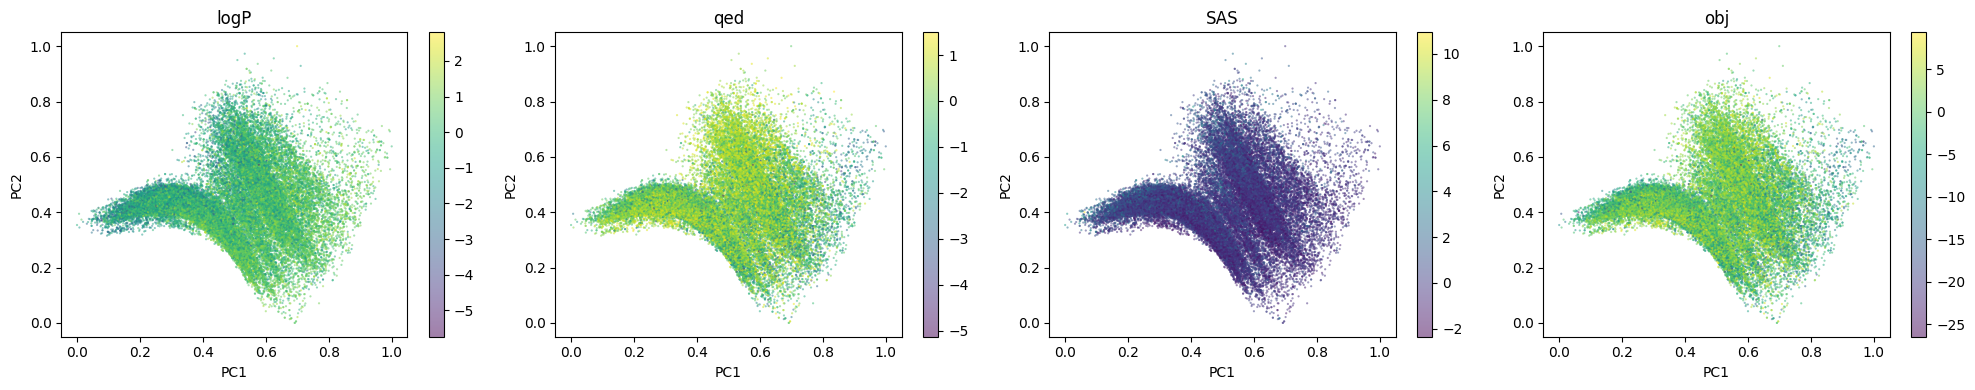

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# do pca and normalize
Z_pca = PCA(n_components=2).fit(Z)
Z_fit = Z_pca.transform(Z)
Z_fit = MinMaxScaler().fit_transform(Z_fit)

explained_variance = Z_pca.explained_variance_ratio_
print(f"Explained variance: {explained_variance}")

df = pd.DataFrame(np.transpose((Z_fit[:,0],Z_fit[:,1])))
df.columns = ['x','y']
df[vae.config.reg_prop_tasks] = prop_df[vae.config.reg_prop_tasks]

fig, axes = plt.subplots(1, len(vae.config.reg_prop_tasks), figsize=(20, 4))

for i, prop in enumerate(vae.config.reg_prop_tasks):
    scatter = axes[i].scatter(df['x'], df['y'], c=df[prop], cmap='viridis', marker='.', s=10, alpha=0.5, edgecolors='none')
    axes[i].set_title(f'{prop}')
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')
    # axes[i].text(0.75, 0.2, f"Explained (PC1): {round(explained_variance[0],2)}", transform=axes[i].transAxes)
    # axes[i].text(0.75, 0.1, f"Explained (PC2): {round(explained_variance[1],2)}", transform=axes[i].transAxes)
    fig.colorbar(scatter, ax=axes[i])

plt.tight_layout()
plt.show()

# Using the VAE with property predictor

In [10]:
# load the data
path = '../checkpoints/smiles/ZINC250K_vae_property_obj_proploss_w0.5'
config = torch.load(os.path.join(path, 'vae_property_config.pt'))
vocab = torch.load(os.path.join(path, 'vae_property_vocab.pt'))
train = moses.get_dataset('train', config)

# Load a model

- Load a model and calculate sample mu and std

In [11]:
vae = VAEPROPERTYUtils(vocab, config, model_path=os.path.join(path, 'vae_property_model_080.pt'))

Model loaded from ../checkpoints/smiles/ZINC250K_vae_property_obj_proploss_w0.5\vae_property_model_080.pt
Using standarized functions? True
Standarization: estimating mu and std values ...

20it [00:15,  1.26it/s]

done!


## Encoder / Decoder


In [12]:
smiles_1 = canonic_smiles('CSCC(=O)NNC(=O)c1c(C)oc(C)c1C')

X_1 = [vae.model.string2tensor(smiles_1, device=vae.model.device)]
z_1 = vae.encode(X_1)
X_r= vae.decode(z_1)

print('{:20s} : {}'.format('Input',smiles_1))
print('{:20s} : {}'.format('Reconstruction',X_r[0]))

print('{:20s} : {} with norm {:.3f}'.format('Z representation',z_1.shape, np.linalg.norm(z_1)))

Input                : CSCC(=O)NNC(=O)c1c(C)oc(C)c1C
Reconstruction       : CC(C)(C)OC(=O)N1CCC(C(=O)NCCc2ccccc2)CC1
Z representation     : (1, 128) with norm 14.831


## Property predictor

In [13]:
print(f'Properties {vae.config.reg_prop_tasks}:')
y_1 = vae.predict_prop_Z(z_1)[0]
print(y_1)

Properties ['logP', 'qed', 'SAS', 'obj']:
tensor([-0.0352])


## Decode several attempts

In [14]:
vae.decode(z_1)

['CC(C)(C)OC(=O)N1CCC(C(=O)NCCc2ccccc2)CC1']

Searching molecules randomly sampled from 5.00 std (z-distance) from the point
Found 2 unique mols, out of 100
SMILES
 0         CC(C)CC(=O)N1CCC(C(=O)NCC2CCCO2)CC1
1    CC(C)(C)OC(=O)N1CCC(C(=O)NCCCO)c2ccccc21
Name: smiles, dtype: object


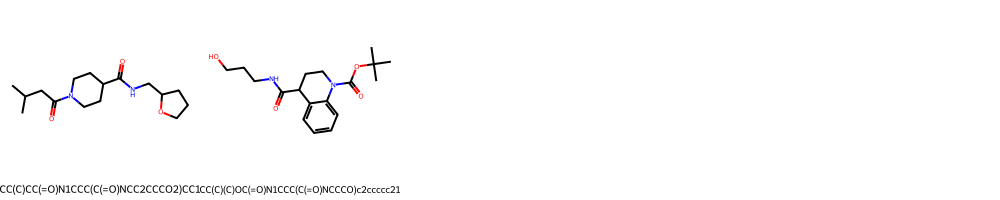

,smiles,distance,count,frequency,mol
0,CC(C)CC(=O)N1CCC(C(=O)NCC2CCCO2)CC1,14.449521,2,0.02,<rdkit.Chem.rdchem.Mol object at 0x0000026B454...
1,CC(C)(C)OC(=O)N1CCC(C(=O)NCCCO)c2ccccc21,15.481386,98,0.98,<rdkit.Chem.rdchem.Mol object at 0x0000026B491...


In [15]:
noise=5.0
print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point'.format(noise))
df = vae.z_to_smiles(z_1, decode_attempts=100, noise_norm=noise)
print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])),sum(df['count'])))
print('SMILES\n', df.smiles)
display(PandasTools.FrameToGridImage(df, column='mol', legendsCol='smiles', molsPerRow=5))
df.head()


Searching molecules randomly sampled from 10.00 std (z-distance) from the point
Found 4 unique mols, out of 100
SMILES
 0       CC(C)CC(=O)N1CCC(C(=O)NCCc2ccccc2)CC1
1         CC(C)CC(=O)N1CCC(C(=O)NCC2CCCO2)CC1
2    CC(C)(C)OC(=O)N1CCC(C(=O)NCCCO)c2ccccc21
3          CC(C)(C)OC(=O)N1CCC(C(=O)NCCCO)CC1
Name: smiles, dtype: object


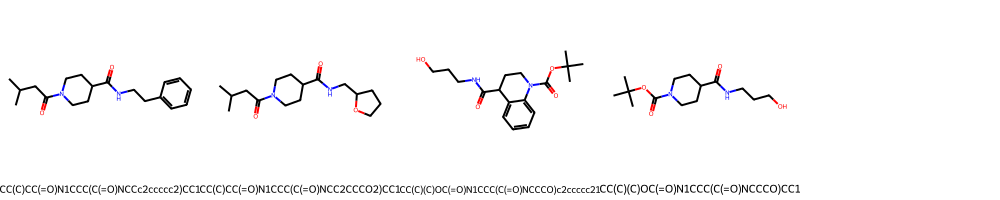

,smiles,distance,count,frequency,mol
0,CC(C)CC(=O)N1CCC(C(=O)NCCc2ccccc2)CC1,13.332422,1,0.01,<rdkit.Chem.rdchem.Mol object at 0x0000026B454...
1,CC(C)CC(=O)N1CCC(C(=O)NCC2CCCO2)CC1,14.449521,5,0.05,<rdkit.Chem.rdchem.Mol object at 0x0000026B454...
2,CC(C)(C)OC(=O)N1CCC(C(=O)NCCCO)c2ccccc21,15.481384,89,0.89,<rdkit.Chem.rdchem.Mol object at 0x0000026B47E...
3,CC(C)(C)OC(=O)N1CCC(C(=O)NCCCO)CC1,16.580679,5,0.05,<rdkit.Chem.rdchem.Mol object at 0x0000026B454...


In [16]:
noise=10.0
print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point'.format(noise))
df = vae.z_to_smiles(z_1, decode_attempts=100, noise_norm=noise)
print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])),sum(df['count'])))
print('SMILES\n', df.smiles)
display(PandasTools.FrameToGridImage(df, column='mol', legendsCol='smiles', molsPerRow=5))
df.head()

## PCA of latent space

In [17]:
vae.config.reg_prop_tasks

['logP', 'qed', 'SAS', 'obj']

In [18]:
Z, data, smiles = vae.ls_sampler_w_prop(size=50000, return_smiles=True)
prop_opt = 'qed'
prop_df = pd.DataFrame(data, columns=vae.config.reg_prop_tasks)
prop_df['smiles'] = smiles
prop_df.head()

20it [00:15,  1.27it/s]


,logP,qed,SAS,obj,smiles
0,-0.755521,-1.404691,0.692896,-7.716353,Cc1nc(C)c(CC(=O)NCc2nc3ccc(C)c(C)c3[nH]2)c(=O)...
1,-0.812562,-0.558053,0.982514,-3.772778,O=S(=O)(c1c[nH]cn1)N1CCc2[nH]nc(-c3ccc(F)cc3)c2C1
2,0.414057,-1.487017,1.149614,-8.584701,COC(=O)c1[nH]c(C)c(C(=O)C(C)N(C)C(=O)c2cccs2)c1C
3,-3.431941,-1.511562,2.700821,-10.258630,O=C(NC1CC2C(=O)NCC(=O)N2C1)c1cc(C(F)(F)F)n[nH]1
4,-0.032002,-0.936884,-0.772466,-3.911956,CCn1c(=O)c(=O)[nH]c2cc(C(=O)Nc3ccc(F)cc3C)ccc21


Explained variance: [0.36786088 0.21727109]


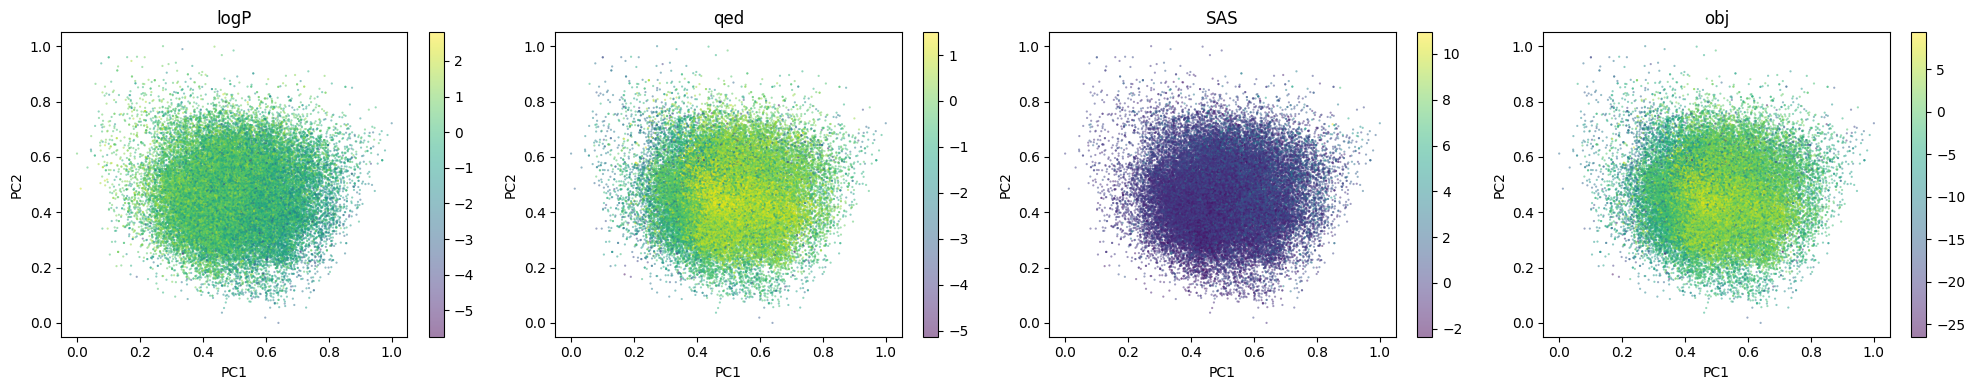

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# do pca and normalize
Z_pca = PCA(n_components=2).fit(Z)
Z_fit = Z_pca.transform(Z)
Z_fit = MinMaxScaler().fit_transform(Z_fit)

explained_variance = Z_pca.explained_variance_ratio_
print(f"Explained variance: {explained_variance}")

df = pd.DataFrame(np.transpose((Z_fit[:,0],Z_fit[:,1])))
df.columns = ['x','y']
df[vae.config.reg_prop_tasks] = prop_df[vae.config.reg_prop_tasks]

fig, axes = plt.subplots(1, len(vae.config.reg_prop_tasks), figsize=(20, 4))

for i, prop in enumerate(vae.config.reg_prop_tasks):
    scatter = axes[i].scatter(df['x'], df['y'], c=df[prop], cmap='viridis', marker='.', s=10, alpha=0.5, edgecolors='none')
    axes[i].set_title(f'{prop}')
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')
    # axes[i].text(0.75, 0.2, f"Explained (PC1): {round(explained_variance[0],2)}", transform=axes[i].transAxes)
    # axes[i].text(0.75, 0.1, f"Explained (PC2): {round(explained_variance[1],2)}", transform=axes[i].transAxes)
    fig.colorbar(scatter, ax=axes[i])

plt.tight_layout()
plt.show()

* Previous version

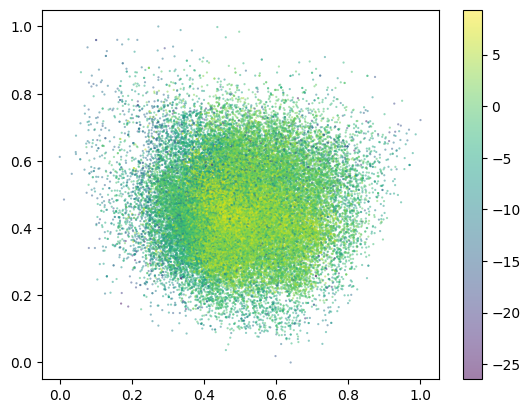

In [538]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# do pca and normalize
Z_pca = PCA(n_components=2).fit_transform(Z)
Z_pca = MinMaxScaler().fit_transform(Z_pca)

df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']
df[prop_opt] = prop_df[prop_opt]

plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
            cmap= 'viridis', marker='.',
            s=10,alpha=0.5, edgecolors='none')
plt.colorbar()
plt.show()

## T-SNE to compare with PCA

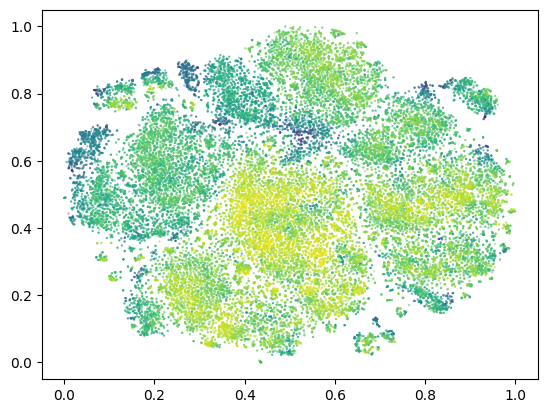

In [330]:
from sklearn.manifold import TSNE

Z_tsne = TSNE(n_components=2).fit_transform(Z)
Z_tsne = MinMaxScaler().fit_transform(Z_tsne)

df = pd.DataFrame(np.transpose((Z_tsne[:,0],Z_tsne[:,1])))
df.columns = ['x','y']
df[prop_opt]=prop_df[prop_opt]

plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
            cmap= 'viridis', marker='.',
            s=10,alpha=0.5, edgecolors='none')
plt.show()